In [1]:
pip install tensorflow numpy matplotlib mcschematic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 1.7 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import mcschematic
import math

# Model

In [3]:
# 1. LOAD DATA
def load_data():
    mnist = tf.keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = np.where(x_train / 255.0 >= 0.5, 1, 0)
    x_test = np.where(x_test / 255.0 >= 0.5, 1, 0)
    return (x_train, y_train), (x_test, y_test)


# 2. TRAINING
def train_pro_model(x_train, y_train, x_test, y_test):
    l1_strength = 0.0005

    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(
            10,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l1(l1_strength),
            bias_regularizer=tf.keras.regularizers.l1(l1_strength),
        ),
        tf.keras.layers.Dense(
            10,
            activation='softmax',
            kernel_regularizer=tf.keras.regularizers.l1(l1_strength),
            bias_regularizer=tf.keras.regularizers.l1(l1_strength),
        ),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
    )

    print(f"Training PRO model (L1: {l1_strength})...")
    model.fit(x_train, y_train, epochs=40, verbose=0)
    return model


# 3. SIMULATION (TARGET 127)
def simulate_optimized_accuracy(model, x_test, y_test):
    print("\n=== OPTIMAL SIMULATION (Hidden ±7 | Output ±127) ===")

    h_layer = model.layers[1]
    w_h, b_h = h_layer.get_weights()
    o_layer = model.layers[2]
    w_o, b_o = o_layer.get_weights()

    # Hidden layer scaling (target ±7)
    all_h = np.concatenate([np.abs(w_h).flatten(), np.abs(b_h).flatten()])
    max_h = np.percentile(all_h, 99.9)
    if max_h == 0:
        max_h = 1.0
    scale_h = 7.0 / max_h

    w_h_int = np.clip(np.round(w_h * scale_h), -7, 7).astype(int)
    b_h_int = np.clip(np.round(b_h * scale_h), -7, 7).astype(int)

    print(f"Hidden scale: {scale_h:.4f} (target ±7)")

    # Output layer scaling (target ±127)
    all_o = np.concatenate([np.abs(w_o).flatten(), np.abs(b_o).flatten()])
    max_o = np.percentile(all_o, 99.9)
    if max_o == 0:
        max_o = 1.0

    scale_o = 127.0 / max_o

    w_o_int = np.clip(np.round(w_o * scale_o), -127, 127).astype(int)
    b_o_int = np.clip(np.round(b_o * scale_o), -127, 127).astype(int)

    print(f"Output scale: {scale_o:.4f} (target ±127)")

    # Forward pass simulation with integer weights
    x_flat = x_test.reshape(x_test.shape[0], -1)

    hidden_raw = np.dot(x_flat, w_h_int) + b_h_int
    hidden_out = np.maximum(0, hidden_raw)

    final_raw = np.dot(hidden_out, w_o_int) + b_o_int

    # Overflow check (16-bit accumulator)
    max_acc = np.max(np.abs(final_raw))
    print(f"Max accumulator: {max_acc} (limit: 32767)")

    if max_acc > 32767:
        print("Warning: overflow detected.")
    else:
        print("Safe: 16-bit adder capacity used efficiently.")

    # Accuracy
    pred = np.argmax(final_raw, axis=1)
    acc = np.mean(pred == y_test) * 100

    print("---------------------------------------------")
    print(f"MINECRAFT ACCURACY: {acc:.2f}%")
    print("---------------------------------------------")

    print("Updating original model with integer-converted weights...")

    # Update model weights (store integer weights as float)
    h_layer.set_weights([w_h_int.astype(float), b_h_int.astype(float)])
    o_layer.set_weights([w_o_int.astype(float), b_o_int.astype(float)])

    loss, keras_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"Keras evaluate accuracy: {keras_acc * 100:.2f}%")

    return model, scale_o


# RUN
(x_train, y_train), (x_test, y_test) = load_data()
# for i in range(3):
#     print(f"\nRun #{i + 1}")
#     model = train_pro_model(x_train, y_train, x_test, y_test)
#     simulate_optimized_accuracy(model, x_test, y_test)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# model_v5 = model

In [5]:
# model_v5.save('model_v5.keras')

In [6]:
model_v5 = tf.keras.models.load_model('model_v5.keras')

In [7]:
def get_items_for_signal(signal_strength):
    """Calculate number of items required to produce a given redstone signal (0–15)."""
    if signal_strength <= 0:
        return 0
    if signal_strength == 1:
        return 1
    if signal_strength >= 15:
        return 27 * 64

    total_slots = 27
    stack_size = 64
    capacity = total_slots * stack_size

    items_needed = math.ceil(((signal_strength - 1) * capacity) / 14)
    return items_needed


def generate_barrel_nbt(items_count):
    """Generate NBT data for a barrel filled with a given number of items."""
    if items_count == 0:
        return ""

    nbt_items = []
    items_remaining = items_count
    slot = 0

    while items_remaining > 0 and slot < 27:
        count = min(64, items_remaining)
        nbt_items.append(
            f'{{Slot:{slot}b, id:"minecraft:cobblestone", Count:{count}b}}'
        )
        items_remaining -= count
        slot += 1

    return "{" + f'Items:[{",".join(nbt_items)}]' + "}"


def to_twos_complement(val):
    """
    Convert integer (-8 to 7) to a 4-bit two's complement redstone signal (0–15).
    """
    val = max(-8, min(7, val))

    if val >= 0:
        return val
    else:
        return 16 + val


def export_schematics_twos_complement(model):
    """Export schematics with safe scaling for both weights and biases."""
    print("\n--- GENERATE SCHEMATIC (SAFE SCALING: WEIGHT + BIAS) ---")

    layer = model.layers[1]
    weights, biases = layer.get_weights()

    max_weight = np.max(np.abs(weights))
    max_bias = np.max(np.abs(biases))
    absolute_max = max(max_weight, max_bias)

    if absolute_max == 0:
        absolute_max = 1.0

    scale_factor = 7.0 / absolute_max

    print(f"Original Max Weight: {max_weight:.4f}")
    print(f"Original Max Bias:   {max_bias:.4f}")
    print(f"Scale Factor:        {scale_factor:.4f}")

    weights_int = np.round(weights * scale_factor).astype(int)
    biases_int = np.round(biases * scale_factor).astype(int)

    print(f"New Weight Range: {weights_int.min()} to {weights_int.max()}")
    print(f"New Bias Range:   {biases_int.min()} to {biases_int.max()}")

    for neuron_idx in range(10):
        schem = mcschematic.MCSchematic()

        w_neuron = weights_int[:, neuron_idx]
        w_grid = w_neuron.reshape(28, 28)

        bias_val = biases_int[neuron_idx]
        bias_signal = to_twos_complement(bias_val)

        print(f"\n=== NEURON {neuron_idx} ===")
        print(f"Bias Integer: {bias_val} | Bias Signal: {bias_signal}")
        print("-" * 40)

        for row in range(28):
            line_str = ""
            for col in range(28):
                weight_val = w_grid[row, col]

                if weight_val == 0:
                    line_str += " . "
                else:
                    line_str += f"{weight_val:2d} "

                signal_strength = to_twos_complement(weight_val)
                items_needed = get_items_for_signal(signal_strength)
                nbt_data = generate_barrel_nbt(items_needed)

                x_pos = col * 2
                y_pos = (27 - row) * 2
                z_pos = 0

                schem.setBlock(
                    (x_pos, y_pos, z_pos),
                    f"minecraft:barrel{nbt_data}"
                )

            print(line_str)

        print("-" * 40)

        filename = f"neuron_{neuron_idx}_twos_comp"
        schem.save(".", filename, version=mcschematic.Version.JE_1_20_1)
        print(f">>> Saved file: {filename}.schem")

    print("\nDone. Bias is now guaranteed to be within -7 to +7.")

In [8]:
export_schematics_twos_complement(model_v5)


--- GENERATE SCHEMATIC (SAFE SCALING: WEIGHT + BIAS) ---
Original Max Weight: 7.0000
Original Max Bias:   7.0000
Scale Factor:        1.0000
New Weight Range: -7 to 5
New Bias Range:   -1 to 7

=== NEURON 0 ===
Bias Integer: 1 | Bias Signal: 1
----------------------------------------
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  1  .  1  1  .  .  1  .  .  .  .  .  .  . 
 .  .  .  .  .  . -2  .  .  . -1  .  .  .  .  .  .  .  .  .  .  .  .  1  .  .  .  . 
 .  .  .  .  .  .  . -1  .  .  .  . -2 -1 -2  .  .  .  . -1  .  .  1  1  2  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  

In [9]:
simulate_optimized_accuracy(model_v5, x_test, y_test)


=== OPTIMAL SIMULATION (Hidden ±7 | Output ±127) ===
Hidden scale: 1.0000 (target ±7)
Output scale: 1.0104 (target ±127)
Max accumulator: 13948 (limit: 32767)
Safe: 16-bit adder capacity used efficiently.
---------------------------------------------
MINECRAFT ACCURACY: 91.42%
---------------------------------------------
Updating original model with integer-converted weights...
Keras evaluate accuracy: 91.42%


(<Sequential name=sequential_12, built=True>, np.float32(1.0104065))

In [10]:
def export_output_layer_debug(model):
    print("\n\n=======================================================")
    print("           OUTPUT LAYER ANALYSIS (Hidden -> Lamps)     ")
    print("=======================================================")

    # Get final (output) layer
    out_layer = model.layers[2]
    weights, biases = out_layer.get_weights()

    # Safe scaling to range -7 to +7
    max_weight = np.max(np.abs(weights))
    max_bias = np.max(np.abs(biases))
    absolute_max = max(max_weight, max_bias)

    if absolute_max == 0:
        absolute_max = 1.0

    scale_factor = 7.0 / absolute_max

    weights_int = np.round(weights * scale_factor).astype(int)
    biases_int = np.round(biases * scale_factor).astype(int)

    print(f"Output Layer Scale Factor: {scale_factor:.4f}")
    print(f"Max Value Used for Scaling: {absolute_max:.4f}")

    # Show biases
    print("\n--- OUTPUT BIASES ---")
    print("Format: [Lamp Index] : Bias Int -> 2's Complement Signal (0–15)")
    for i in range(10):
        val = biases_int[i]
        signal = to_twos_complement(val)
        print(f"Lamp {i} : Bias {val:>2} -> Signal {signal}")

    # Show weight matrix
    print("\n--- WEIGHT MATRIX (Hidden → Output) ---")
    print("Row = From Hidden Neuron #X")
    print("Col = To Output Lamp #Y")
    print("-" * 60)

    header = "      " + " ".join([f"L{i}" for i in range(10)])
    print(header)
    print("-" * 60)

    for h in range(10):
        row_str = f"H-{h} |"
        for o in range(10):
            val = weights_int[h][o]
            row_str += f"{val:3d}"
        print(row_str)

    print("-" * 60)

In [11]:
export_output_layer_debug(model_v5)



           OUTPUT LAYER ANALYSIS (Hidden -> Lamps)     
Output Layer Scale Factor: 0.0551
Max Value Used for Scaling: 127.0000

--- OUTPUT BIASES ---
Format: [Lamp Index] : Bias Int -> 2's Complement Signal (0–15)
Lamp 0 : Bias  0 -> Signal 0
Lamp 1 : Bias  0 -> Signal 0
Lamp 2 : Bias  0 -> Signal 0
Lamp 3 : Bias -1 -> Signal 15
Lamp 4 : Bias  0 -> Signal 0
Lamp 5 : Bias  0 -> Signal 0
Lamp 6 : Bias  0 -> Signal 0
Lamp 7 : Bias  0 -> Signal 0
Lamp 8 : Bias -1 -> Signal 15
Lamp 9 : Bias  0 -> Signal 0

--- WEIGHT MATRIX (Hidden → Output) ---
Row = From Hidden Neuron #X
Col = To Output Lamp #Y
------------------------------------------------------------
      L0 L1 L2 L3 L4 L5 L6 L7 L8 L9
------------------------------------------------------------
H-0 |  1 -4  1 -3  1  0  1 -4  2 -2
H-1 | -2 -3 -4  0  3  2 -3  1  0  3
H-2 |  0 -4  0  1  0  0  0  4 -2 -3
H-3 |  0  0  6  5 -2 -1 -2  3 -3 -6
H-4 |  0 -1  3  1 -6  1 -5  3  0 -1
H-5 | -1  0  0  0  1 -7 -2  2  1  2
H-6 |  0  3 -4 -3  0  6 -

In [12]:
def export_full_model_params(model, filename="FULL_MODEL_REDSTONE.txt"):
    print(f"--- EXPORTING FULL MODEL DATA TO {filename} ---")

    with open(filename, "w") as f:
        f.write("=== TECHNICAL DOCUMENT: REDSTONE NEURAL NETWORK ===\n")
        f.write("Integer Range: -7 to +7\n")
        f.write("Negative Method: 2's Complement or Subtractor\n")
        f.write("==============================================\n\n")

        # Hidden Layer
        h_layer = model.layers[1]
        w_h, b_h = h_layer.get_weights()

        # Safe scaling (weights and bias)
        max_w = np.max(np.abs(w_h))
        max_b = np.max(np.abs(b_h))
        abs_max_h = max(max_w, max_b)
        if abs_max_h == 0:
            abs_max_h = 1.0

        scale_h = 7.0 / abs_max_h

        w_h_int = np.round(w_h * scale_h).astype(int)
        b_h_int = np.round(b_h * scale_h).astype(int)

        f.write("--- [LAYER 1] HIDDEN LAYER (784 Input -> 10 Neurons) ---\n")
        f.write(f"Scale Factor: {scale_h:.4f} (Max Value: {abs_max_h:.4f})\n\n")

        # Hidden Bias
        f.write("HIDDEN LAYER BIASES:\n")
        for i in range(10):
            f.write(f"Neuron {i}: {b_h_int[i]}\n")
        f.write("\n")

        # Hidden Weights (visual 28x28 grid)
        for n in range(10):
            f.write(f"--- Weights for Hidden Neuron {n} ---\n")
            w_grid = w_h_int[:, n].reshape(28, 28)
            for row in range(28):
                line = ""
                for col in range(28):
                    val = w_grid[row, col]
                    if val == 0:
                        line += " . "
                    else:
                        line += f"{val:2d} "
                f.write(line + "\n")
            f.write("\n")

        # Output Layer
        o_layer = model.layers[2]
        w_o, b_o = o_layer.get_weights()

        # Safe scaling
        max_w_o = np.max(np.abs(w_o))
        max_b_o = np.max(np.abs(b_o))
        abs_max_o = max(max_w_o, max_b_o)
        if abs_max_o == 0:
            abs_max_o = 1.0

        scale_o = 7.0 / abs_max_o

        w_o_int = np.round(w_o * scale_o).astype(int)
        b_o_int = np.round(b_o * scale_o).astype(int)

        f.write("\n==============================================\n")
        f.write("--- [LAYER 2] OUTPUT LAYER (10 Hidden -> 10 Lamps) ---\n")
        f.write(f"Scale Factor: {scale_o:.4f} (Max Value: {abs_max_o:.4f})\n\n")

        # Output biases
        f.write("OUTPUT LAYER BIASES:\n")
        for i in range(10):
            f.write(f"Lamp {i}: {b_o_int[i]}\n")
        f.write("\n")

        # Output connection matrix
        f.write("CONNECTION MATRIX (Row=Hidden, Column=Lamp):\n")
        header = "      " + " ".join([f"L{i}" for i in range(10)])
        f.write(header + "\n")
        f.write("-" * 50 + "\n")

        for h in range(10):
            row_str = f"H-{h} |"
            for o in range(10):
                val = w_o_int[h][o]
                row_str += f"{val:3d}"
            f.write(row_str + "\n")

    print("Success! FULL_MODEL_REDSTONE.txt has been updated.")


def trace_redstone_logic(model, x_test, y_test, image_index=0):
    print(f"\n\n>>> TRACING REDSTONE LOGIC FOR IMAGE INDEX {image_index} <<<")

    # Input data
    input_grid = x_test[image_index].reshape(28, 28)
    img = input_grid.flatten()
    true_label = y_test[image_index]

    print(f"True Label: {true_label}")

    # Hidden layer scaling
    h_layer = model.layers[1]
    w_h, b_h = h_layer.get_weights()

    abs_max_h = max(np.max(np.abs(w_h)), np.max(np.abs(b_h)))
    if abs_max_h == 0:
        abs_max_h = 1.0
    scale_h = 7.0 / abs_max_h

    w_h_int = np.round(w_h * scale_h).astype(int)
    b_h_int = np.round(b_h * scale_h).astype(int)

    print("\n[STEP 1] HIDDEN LAYER (ReLU Output)")
    hidden_outputs = []

    for n in range(10):
        raw_sum = np.dot(img, w_h_int[:, n])
        total = raw_sum + b_h_int[n]
        output = max(0, total)
        hidden_outputs.append(output)

    # Output layer
    o_layer = model.layers[2]
    w_o, b_o = o_layer.get_weights()

    abs_max_o = max(np.max(np.abs(w_o)), np.max(np.abs(b_o)))
    if abs_max_o == 0:
        abs_max_o = 1.0
    scale_o = 7.0 / abs_max_o

    w_o_int = np.round(w_o * scale_o).astype(int)
    b_o_int = np.round(b_o * scale_o).astype(int)

    print("\n[STEP 2] OUTPUT LAYER (Lamps)")
    print("-" * 50)
    print(f"{'Lamp':<8} | {'Bias':<5} | {'Total Signal':<12} | {'Bar'}")
    print("-" * 50)

    final_scores = []
    for digit in range(10):
        weighted_sum = np.dot(hidden_outputs, w_o_int[:, digit])
        final_total = weighted_sum + b_o_int[digit]
        final_scores.append(final_total)

        bar_len = int(max(0, final_total) / 5)
        bar_char = "█" * bar_len
        print(f"Lamp {digit:<2} | {b_o_int[digit]:<5} | {final_total:<12} | {bar_char}")

    pred = np.argmax(final_scores)

    print("-" * 50)
    print(f"Prediction: {pred} | True Answer: {true_label}")
    status = "CORRECT" if pred == true_label else "WRONG"
    print(f"Result: {status}")

    # Visualization
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(input_grid, cmap='gray')
    plt.title(f"Input Digit: {true_label}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    colors = ['gray'] * 10
    colors[pred] = 'green'
    if pred != true_label:
        colors[true_label] = 'red'

    bars = plt.bar(range(10), final_scores, color=colors)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval),
                 ha='center', va='bottom')

    plt.xlabel("Output Lamp")
    plt.ylabel("Signal Strength")
    plt.title(f"Output Signals — Predicted {pred}")
    plt.xticks(range(10))
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

--- EXPORTING FULL MODEL DATA TO FULL_MODEL_REDSTONE.txt ---
Success! FULL_MODEL_REDSTONE.txt has been updated.


>>> TRACING REDSTONE LOGIC FOR IMAGE INDEX 0 <<<
True Label: 7

[STEP 1] HIDDEN LAYER (ReLU Output)

[STEP 2] OUTPUT LAYER (Lamps)
--------------------------------------------------
Lamp     | Bias  | Total Signal | Bar
--------------------------------------------------
Lamp 0  | 0     | 47           | █████████
Lamp 1  | 0     | -161         | 
Lamp 2  | 0     | 37           | ███████
Lamp 3  | -1    | 106          | █████████████████████
Lamp 4  | 0     | -300         | 
Lamp 5  | 0     | -50          | 
Lamp 6  | 0     | -368         | 
Lamp 7  | 0     | 229          | █████████████████████████████████████████████
Lamp 8  | -1    | -27          | 
Lamp 9  | 0     | 45           | █████████
--------------------------------------------------
Prediction: 7 | True Answer: 7
Result: CORRECT


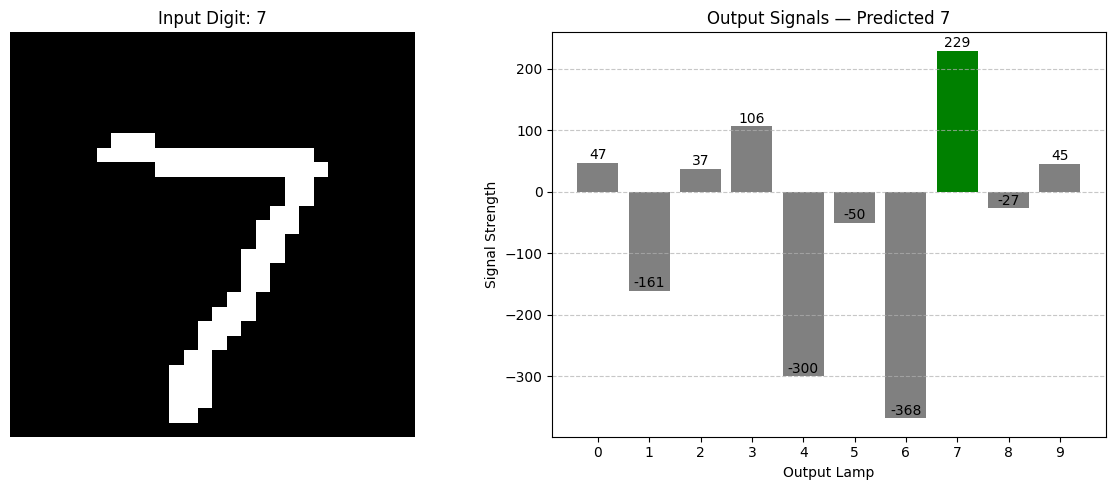

In [13]:
export_full_model_params(model_v5)
trace_redstone_logic(model_v5, x_test, y_test, image_index=0)